# Real data analysis

Now that we know where ultrasound signals come from, let's (re-)analyze real data from a real human brain to see if we can measure (proxies of) neural activity with ultrafast ultrasound images. We'll cover topics including motion compensation and modeling the hemodynamic response.

Let's load up the data from [Rabut et al. (2024), *A window to the brain: ultrasound imaging of human neural activity through an acoustically transparent cranial prosthetic*](https://www.biorxiv.org/content/10.1101/2023.06.14.544094v1.full.pdf). It's a dataset that captures activity in the motor cortex through a transparent window in a human subject. It illustrates core topics in fUS data analysis.

# Download the data

In [1]:
%%bash
set -euo pipefail

# Download only if data.zip doesn't already exist (and isn't empty)
if [ ! -s data.zip ]; then
  echo "Downloading data.zip…"
  curl -L 'https://data.caltech.edu/records/f3y3k-em558/files/data.zip?download=1' -o data.zip \
    --fail --show-error --silent \
    --continue-at - \                # resume if a partial file exists
    --connect-timeout 20 \           # fail fast if no connection
    --max-time 600 \                 # hard cap (seconds)
    --retry 3 --retry-connrefused \  # a few retries on transient errors
    --speed-time 30 --speed-limit 1024  # abort if <1 KB/s for 30s
else
  echo "data.zip already exists; skipping download."
fi

# Unzip without overwriting existing files
# unzip -n data.zip -d ../data

data.zip already exists; skipping download.


In [2]:
import h5py
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal
import scipy.stats
from IPython.display import HTML
from numpy.linalg import lstsq
from scipy.linalg import svd
from scipy.stats import gamma as gamma_dist

f = h5py.File("../data/data/human/S2R2.mat", "r")
f

<HDF5 file "S2R2.mat" (mode r)>

In [3]:
f.keys()

<KeysViewHDF5 ['#refs#', 'UF', 'angiogram', 'dop', 'run_label', 'task', 'timestamps']>

The `angiogram` key contains an image which captures the average signal in the volume over the trial. The geometry can be picked off from the accompanying Matlab file, `human_glm_task.m`, [available here](https://zenodo.org/records/11100191).

```
x_pixelsize = 0.3;
z_pixelsize = data.UF.Lambda;
```

Text(0, 0.5, '← increasing depth          mm       transducer →')

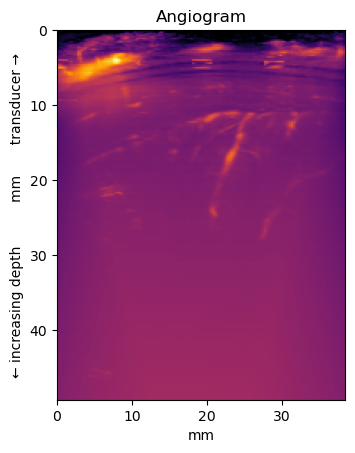

In [4]:
x_pixelsize = 0.3  # in mm
z_pixelsize = f["UF"]["Lambda"][:][0]  # in mm
plt.imshow(
    np.log(f["angiogram"][:].T[:, ::-1]),
    cmap="inferno",
    extent=[
        0,
        f["angiogram"].shape[0] * x_pixelsize,
        f["angiogram"].shape[1] * z_pixelsize,
        0,
    ],
    aspect="equal",
)
plt.title("Angiogram")
plt.xlabel("mm")
plt.ylabel("← increasing depth          mm       transducer →")

What are we looking at? Figure 6C helps us interpret this image:

![images/vascular.png](images/vascular.png)

At the top is the PMMA implant; then we hit the brain surface; finally, we see the vasculature under the brain surface.

Now let's look at the Power Doppler data.

In [5]:
# Check the shape of the Doppler data
print("Doppler data shape:", f["dop"].shape)

Doppler data shape: (270, 128, 240)


Let's visualize this data over time. We'll skip every third frame so it's faster to render.

In [6]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 6))

# Get the Doppler data
dop_data = np.log(f["dop"][:][:, ::-1, :]).transpose(0, 2, 1)
n_frames = dop_data.shape[0]

# Initialize the plot with the first frame
im = ax.imshow(
    dop_data[0, :, :],
    cmap="inferno",
    extent=[0, dop_data.shape[2] * x_pixelsize, dop_data.shape[1] * z_pixelsize, 0],
    aspect="equal",
)
ax.set_title(f"Frame 0/{n_frames}")
ax.set_xlabel("mm")
ax.set_ylabel("← increasing depth          mm       transducer →")
plt.colorbar(im, ax=ax)


# Animation update function
def update(frame):
    im.set_array(dop_data[frame, :, :])
    ax.set_title(f"Frame {frame}/{n_frames}")
    return [im]


# Create animation
anim = animation.FuncAnimation(
    fig,
    update,
    frames=np.arange(256, n_frames, step=3),
    interval=50,
    blit=True,
    repeat=True,
)

plt.close(fig)  # Prevents static image display

# Display the animation
HTML(anim.to_jshtml())

Animation removed for publishing.

Very cool! We see a slice of the brain over time.

# Dealing with artifacts

The Power Doppler data in this dataset is preprocessed with clutter filtering to mitigate global motion artifacts *within frames*. However, we still see two types of artifacts *across frames* in the data:

* There are high variance pixels at the top of the volume, above the brain surface
* The brain is shifting over time, which is clearly visible if you look at the postcentral sulcus.

We can identify the approximate location of the brain surface by looking at the standard deviation over time as a function of depth.

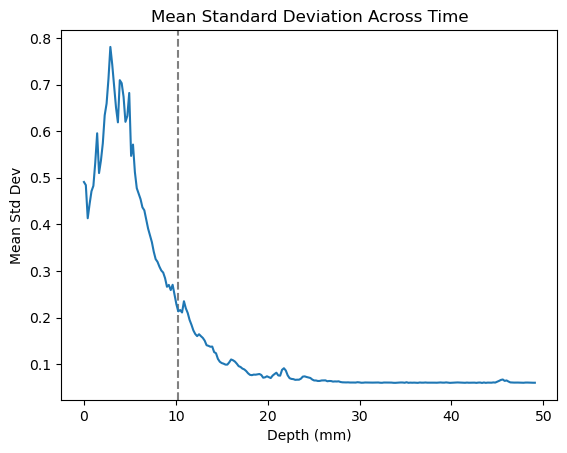

In [7]:
plt.axvline(50 * z_pixelsize, color="gray", linestyle="--")
plt.plot(
    np.arange(dop_data.shape[1]) * z_pixelsize, np.std(dop_data, axis=0).mean(axis=1)
)
plt.title("Mean Standard Deviation Across Time")
plt.xlabel("Depth (mm)")
plt.ylabel("Mean Std Dev")
plt.show()

To deal with the first artifact, we'll crop the top of the volume. To deal with the second artifact, we'll use a non-rigid registration method, NoRMCorre, which is located in the CaImAn package. Originally intended for calcium analysis, NoRMCorre can effectively perform non-rigid image registration to minimize the amount of planar motion in our movie.[CaImAn](https://github.com/flatironinstitute/CaImAn) is a little tricky to install; follow route A in the `README.md` on Github to install it.

Note that it's important to first crop, *then* align. The significant contrast at the top of the volume means that NoRMCorre will focus on aligning that region in the top tiles, discounting the lower-contrast volume inside the brain, which is what we care about aligning.

To run the registration, we'll save an hdf5 file with the corresponding data, then use `MotionCorrect` on the file.

In [8]:
# Make sure to select only brain here
# Create a new HDF5 file to save the aligned data
crop = slice(50, -1)
h5f = h5py.File("data_logged_unaligned.h5", "w")
h5f.create_dataset("dop", data=dop_data[:, crop, :])
h5f.close()

In [9]:
import caiman
from caiman.motion_correction import MotionCorrect

fname = "data_logged_unaligned.h5"

h5f = h5py.File(fname, "r")
template = h5f["dop"][:].mean(axis=0)
h5f.close()

max_shifts = (15, 15)
strides = (32, 32)
overlaps = (16, 16)
max_deviation_rigid = 3
shifts_opencv = True
border_nan = "copy"
upsample_factor_grid = 16

mc = MotionCorrect(
    fname,
    max_shifts=max_shifts,
    strides=strides,
    overlaps=overlaps,
    max_deviation_rigid=max_deviation_rigid,
    shifts_opencv=shifts_opencv,
    nonneg_movie=False,
    border_nan=border_nan,
    upsample_factor_grid=upsample_factor_grid,
)

mc.pw_rigid = True

mc.motion_correct(save_movie=True, template=template)

# Load up the motion corrected data
m_els = caiman.load(mc.fname_tot_els)

One sanity check that this worked well is to compare the mean power doppler images before and after.

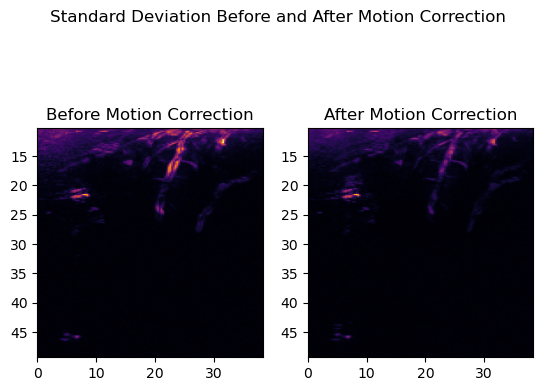

In [10]:
dop_data_std = dop_data[:, crop, :].std(axis=0)
dop_data_std_aligned = m_els.std(axis=0)

z_rg = (crop.start * z_pixelsize, dop_data.shape[1] * z_pixelsize)

plt.subplot(121)
plt.imshow(
    dop_data_std,
    cmap="inferno",
    vmax=dop_data_std.max(),
    vmin=dop_data_std.min(),
    extent=[0, dop_data_std.shape[1] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("Before Motion Correction")
plt.subplot(122)
plt.imshow(
    dop_data_std_aligned,
    cmap="inferno",
    vmax=dop_data_std.max(),
    vmin=dop_data_std.min(),
    extent=[0, dop_data_std_aligned.shape[1] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("After Motion Correction")
plt.suptitle("Standard Deviation Before and After Motion Correction")
plt.show()

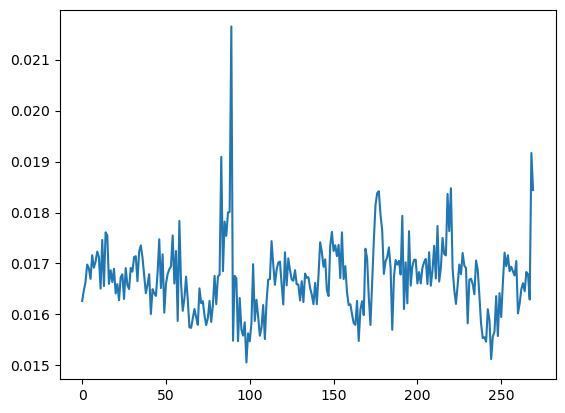

In [11]:
plt.plot(((np.diff(m_els)) ** 2).mean(axis=1).mean(axis=1))

We can see that the standard deviation has been suppressed, especially around that big central artery, which seems to exhibit less ghosting after motion correction.

In [12]:
# Create figure and axis
fig, (ax1, ax2) = plt.subplots(figsize=(8, 6), ncols=2)

dop_data_cropped = dop_data[:, crop, :]

# Get the Doppler data
n_frames = dop_data.shape[0] // 3

# Initialize the plot with the first frame
im1 = ax1.imshow(
    dop_data_cropped[0, :, :],
    cmap="inferno",
    vmin=dop_data_cropped.min(),
    vmax=dop_data_cropped.max(),
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
im2 = ax2.imshow(
    m_els[0, :, :],
    cmap="inferno",
    vmin=dop_data_cropped.min(),
    vmax=dop_data_cropped.max(),
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
)
ax1.set_title(f"Before")
ax2.set_title(f"After")


# Animation update function
def update(frame):
    im1.set_array(dop_data_cropped[frame * 3, :, :])
    im2.set_array(m_els[frame * 3, :, :])
    return [im1, im2]


# Create animation
anim = animation.FuncAnimation(
    fig, update, frames=n_frames, interval=50, blit=True, repeat=True
)

plt.close(fig)  # Prevents static image display

# Display the animation
HTML(anim.to_jshtml())

Animation removed for publishing.

It's not perfect, but we definitely see an improvement in the stability of the volume.

# Modeling the neural response

Let's now try to recover the neural response over time. Let's first look at the trial structure:

Text(0, 0.5, 'Motion on')

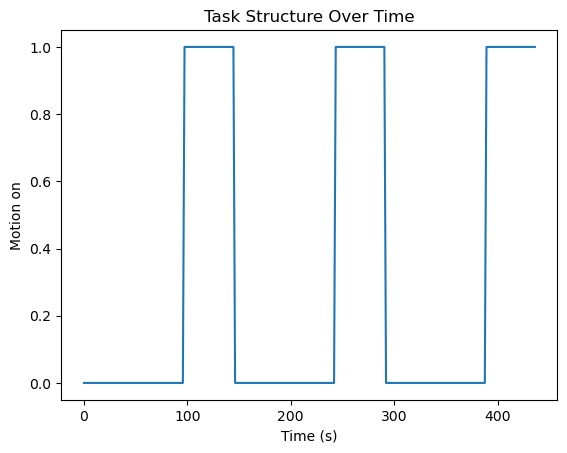

In [13]:
plt.plot(f["timestamps"][:][0, :], f["task"][:])
plt.title("Task Structure Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Motion on")

At times when the `task` variable is set to 1, the patient is instructed to move a joystick to trace out a figure. Thus, we expect that there will be lagged activity in their motor cortex. Let's first examine the singular vectors of the data to see if the image seems to track the trial structure.

In [14]:
m_els.shape

(270, 189, 128)

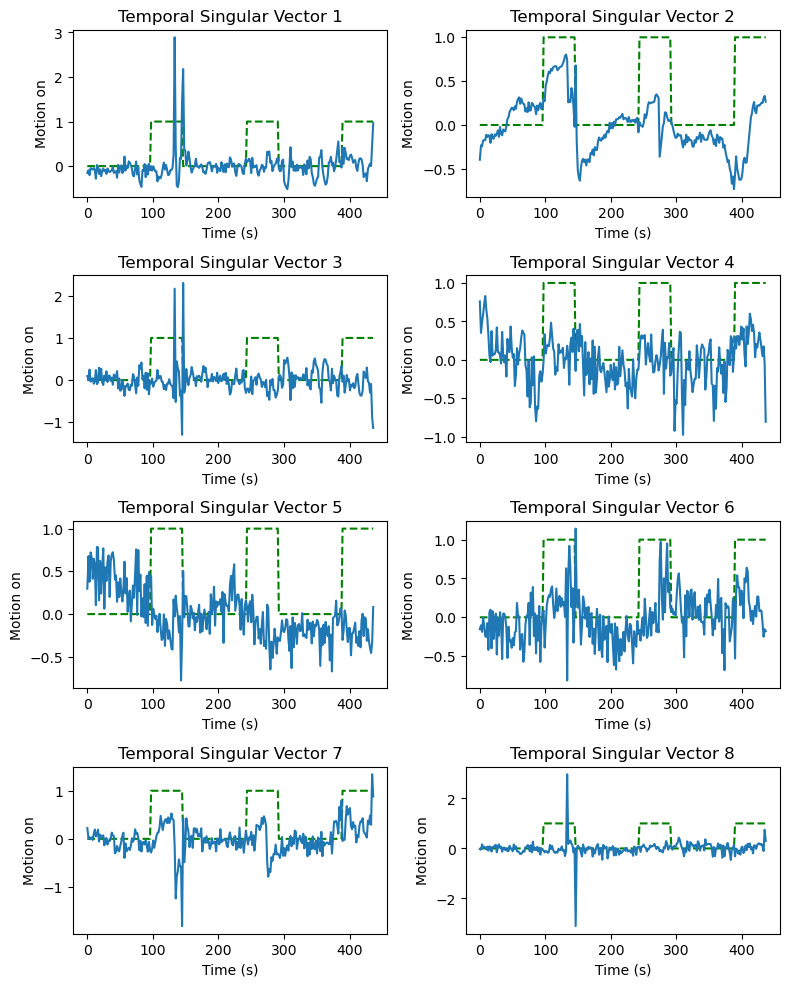

In [15]:
A = m_els.reshape(m_els.shape[0], -1)

U, S, V = svd(A - A.mean(axis=0, keepdims=True), full_matrices=False)
plt.figure(figsize=(8, 12))
for i in range(8):
    plt.subplot(5, 2, i + 1)
    plt.plot(f["timestamps"][:][0, :], f["task"][:], "g--")
    plt.plot(f["timestamps"][:][0, :], U[:, i] * 5)
    plt.title("Task Structure Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Motion on")

    plt.title(f"Temporal Singular Vector {i+1}")
plt.tight_layout()

That looks promising---we definitely see the signal waxing and waning in sync with the trial structure.

## Estimating the time lag between task onset and neural activity

Notice that the peaks seem a bit lagged compared with the start of the "on" periods---this is in line with what we expect from the hemodynamic responses function, which tends to lag neural activity. A coarse way to determine the lag between neural activity and functional activity is to run a regression between lagged task indicators and the PD signals. The quality of the fit ($R^2$) tells us how aligned the two time-series are, giving us a coarse measure of optimal time lag. Note that we add a linear confounder to the regression to deal with drift; we could also add more confounders for faster drifts.

In [16]:
Y = np.array(m_els).reshape(m_els.shape[0], -1)
Y = Y - Y.mean(axis=0, keepdims=True) / Y.std(axis=0, keepdims=True)

rs = []
r0 = f["task"][:].squeeze()
lags = np.arange(-10, 10)
for lag in lags:
    r = np.roll(r0, lag)
    if lag > 0:
        r[:lag] = 0
    elif lag < 0:
        r[lag:] = 0
    X = np.column_stack((r, np.ones_like(r), np.arange(len(r))))
    B, residuals, rank, s = lstsq(X, Y, rcond=None)
    rs.append(residuals)

B_base, residuals_base, rank, s = lstsq(X[:, -2:], Y, rcond=None)

Text(0.5, 1.0, 'Mean R² vs Lag between Task and PD Signals')

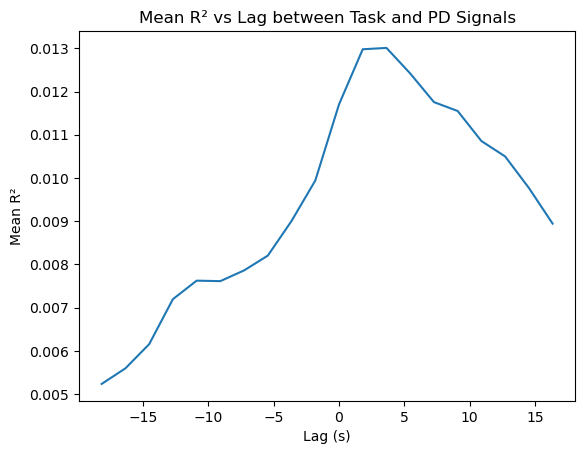

In [17]:
dt = f["timestamps"][0, 1] - f["timestamps"][0, 0]
r2s = 1 - np.array(rs).T / residuals_base.reshape((-1, 1))
plt.plot(lags * dt, r2s.mean(axis=0))
plt.xlabel("Lag (s)")
plt.ylabel("Mean R²")
plt.title("Mean R² vs Lag between Task and PD Signals")

The optimal lag seems to be around 5 seconds, which is right in line with the [hemodynamic literature](https://pmc.ncbi.nlm.nih.gov/articles/PMC3318970/). In fact, the "canonical HRF" implemented in SPM---a classic Matlab-based analysis toolbox---which is given by a sum of two gamma functions, peaks at about 5 seconds.

Text(0.5, 1.0, 'Canonical Hemodynamic Response Function (HRF)')

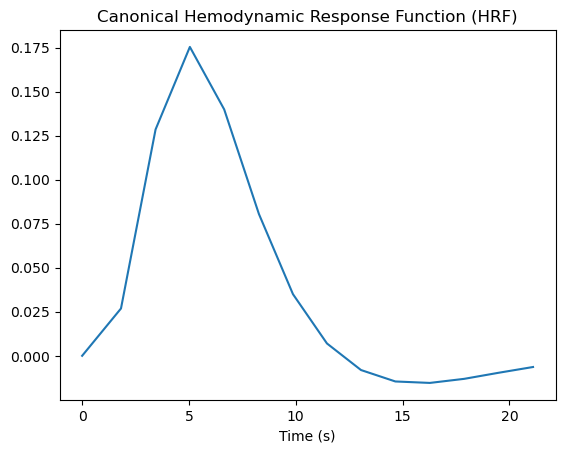

In [18]:
def canonical_hrf_and_derivs_scipy(
    t,
    peak_delay=6.0,  # seconds
    under_delay=16.0,  # seconds
    peak_disp=1.0,  # scale (θ)
    under_disp=1.0,  # scale (θ)
    p_u_ratio=6.0,  # peak-to-undershoot amplitude ratio
    onset=0.0,  # onset shift (s)
    normalize_area=True,  # normalize ∫h(t)dt = 1 over provided t
):
    """
    Canonical (SPM-style) HRF and its first and second *temporal* derivatives at timestamps t,
    using SciPy's gamma pdf.

    h(t) = g1(t) - (1/p_u_ratio) * g2(t)
    where g1 ~ Gamma(k1, θ1), g2 ~ Gamma(k2, θ2),
    with k ≈ delay/disp and θ = disp. Derivatives are analytical.

    Returns
    -------
    h, h1, h2 : np.ndarray
        HRF, dh/dt, d²h/dt² evaluated at t.
    """
    t = np.asarray(t, dtype=float)
    tt = np.clip(t - onset, a_min=0.0, a_max=None)

    # Convert delays/dispersion to Gamma(shape k, scale θ)
    k1, th1 = peak_delay / peak_disp, peak_disp
    k2, th2 = under_delay / under_disp, under_disp

    # Gamma pdfs via SciPy (shape=a=k, scale=θ). Support t=0 by zeroing negatives.
    g1 = gamma_dist.pdf(tt, a=k1, scale=th1)
    g2 = gamma_dist.pdf(tt, a=k2, scale=th2)

    # Analytical time-derivatives of the gamma pdf:
    # f'(t) = ((k-1)/t - 1/θ) f(t)
    # f''(t) = [ - (k-1)/t^2 + ((k-1)/t - 1/θ)^2 ] f(t)
    eps = 1e-12
    inv_t = 1.0 / np.maximum(tt, eps)

    coef1 = (k1 - 1.0) * inv_t - (1.0 / th1)
    coef2 = (k2 - 1.0) * inv_t - (1.0 / th2)

    g1d = coef1 * g1
    g2d = coef2 * g2
    g1dd = (-(k1 - 1.0) * inv_t**2 + coef1**2) * g1
    g2dd = (-(k2 - 1.0) * inv_t**2 + coef2**2) * g2

    h = g1 - (1.0 / p_u_ratio) * g2
    h1 = g1d - (1.0 / p_u_ratio) * g2d
    h2 = g1dd - (1.0 / p_u_ratio) * g2dd

    # Zero everything prior to onset exactly (optional but tidy)
    pre = t < onset
    if pre.any():
        h[pre] = 0.0
        h1[pre] = 0.0
        h2[pre] = 0.0

    return h, h1, h2


hrf, hrf_dt, hrf_ddt = canonical_hrf_and_derivs_scipy(f["timestamps"][:][0, :14])
plt.plot(f["timestamps"][:][0, :14], hrf, label="Canonical HRF")
plt.xlabel("Time (s)")
plt.title("Canonical Hemodynamic Response Function (HRF)")

# Fitting the data with a GLM

Now that we've convinced ourselves that the canonical hemodynamic response function is a decent approximation of how motor cortex responses when a person is instructed to operate a joystick, we can fit a GLM to the data to see which pixels are responsive. We model the response of a pixel as:

$$y(t) = \beta_{hrf} T * f + \beta_{lin} t + \gamma$$

Here:

* $T$ is the vector corresponding to task structure
* $f$ is the hemodynamic response function
* $T * f$ is the convolution of the task structure vector with the HRF
* $\beta_{lin} t$ is a term corresponding to drift. Remember, nothing says that the signals we're measuring are stationary
* $\gamma$ is a baseline

We can pack all the pixels into a matrix $Y$ which dimensions `time x pixels`; similarly, we can pack the regressors (right hand side of the equation) into a matrix $X$. Then we can solve this is a multiple regression:

$$\arg \min_W ||Y-XW||^2$$

This is the General Linear Model, and we can solve it directly using least-squares.

In [19]:
r_hrf = scipy.signal.convolve(f["task"][:][:, 0], hrf, mode="full")[: len(f["task"])]

Y = m_els.reshape(m_els.shape[0], -1)
Y = Y / Y.std(axis=0)
X = np.vstack([r_hrf, np.ones_like(r_hrf), np.arange(len(r_hrf)) / len(r_hrf)]).T

B, residuals, rank, s = lstsq(X, Y, rcond=None)
B_baseline, residuals_baseline, rank, s = lstsq(X[:, -2:], Y, rcond=None)
r2 = 1 - residuals / residuals_baseline

Let's do the same with a model with just the nuisance parameters; from that, we can obtain an $R^2$ value:

In [20]:
B_baseline, residuals_baseline, rank, s = lstsq(X[:, -2:], Y, rcond=None)
r2 = 1 - residuals / residuals_baseline

What does that look like?

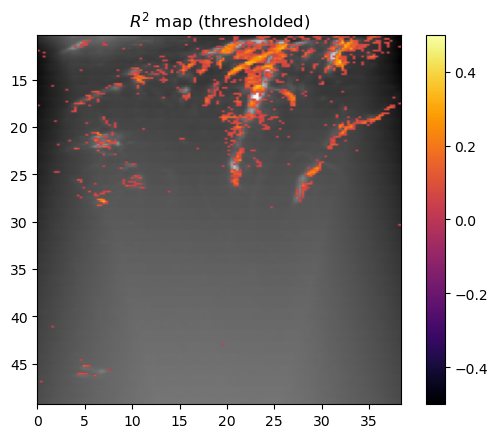

In [21]:
threshold = 0.05  # Totally arbitrary
meets_threshold = 1.0 * ((1 - residuals / residuals_baseline) > threshold)

plt.imshow(
    m_els.mean(axis=0),
    cmap="gray",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.imshow(
    (1 - residuals / residuals_baseline).reshape(m_els.shape[1], m_els.shape[2]),
    alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]),
    clim=(-0.5, 0.5),
    cmap="inferno",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("$R^2$ map (thresholded)")
plt.colorbar()

Nice! We see that most of the pixels which are modulated by the task are around the visible arteries.

Quick sanity check: did our preprocessing help? Let's do the same process on the raw data prior to alignment.

In [22]:
Y = dop_data_cropped.reshape(m_els.shape[0], -1)
Y = Y / Y.std(axis=0)
X = np.vstack([r_hrf, np.ones_like(r_hrf), np.arange(len(r_hrf)) / len(r_hrf)]).T

B, residuals, rank, s = lstsq(X, Y, rcond=None)
B_baseline, residuals_baseline, rank, s = lstsq(X[:, -2:], Y, rcond=None)
r2_nopreprocessing = 1 - residuals / residuals_baseline

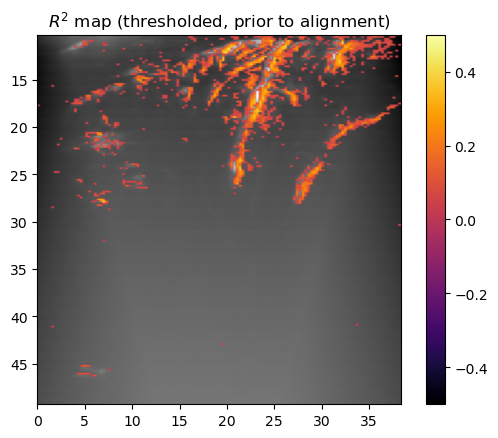

In [23]:
threshold = 0.05  # Totally arbitrary
meets_threshold = 1.0 * ((1 - residuals / residuals_baseline) > threshold)

plt.imshow(
    m_els.mean(axis=0),
    cmap="gray",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.imshow(
    (1 - residuals / residuals_baseline).reshape(m_els.shape[1], m_els.shape[2]),
    alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]),
    clim=(-0.5, 0.5),
    cmap="inferno",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("$R^2$ map (thresholded, prior to alignment)")
plt.colorbar()

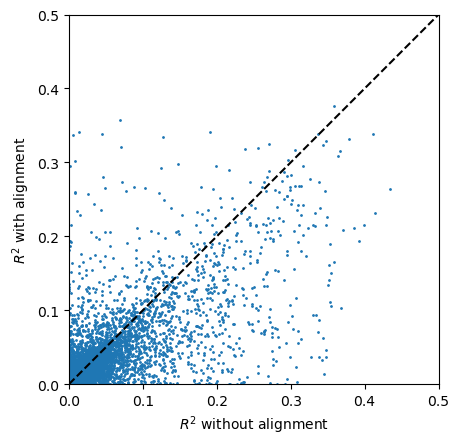

In [24]:
plt.plot(r2_nopreprocessing, r2, ".", markersize=2)
plt.xlabel("$R^2$ without alignment")
plt.ylabel("$R^2$ with alignment")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.gca().set_aspect("equal", adjustable="box")

Actually, the processing *decreased* the number of high $R^2$ pixels. That's perhaps surprising, but it could happen if there's a consistent spatial shift during movement that we've succesfully corrected for:

np.float64(-0.27812267367683474)

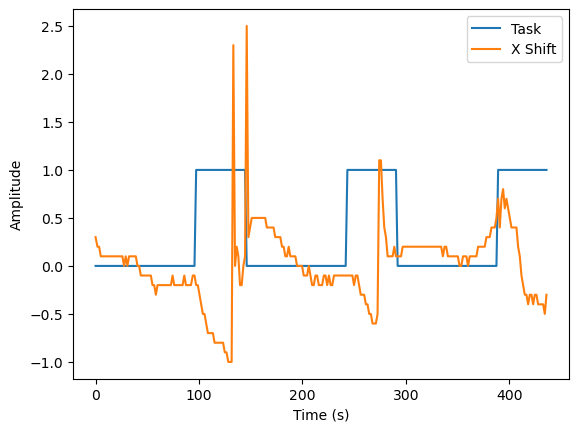

In [25]:
plt.plot(f["timestamps"][:][0, :], f["task"][:], label="Task")
plt.plot(
    f["timestamps"][:][0, :], np.array([x[5] for x in mc.y_shifts_els]), label="X Shift"
)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
np.corrcoef(f["task"][:].squeeze(), np.array([x[5] for x in mc.y_shifts_els]))[0, 1]

Indeed, it does look like there's a spatial shift with some temporal correlation to the task. The brain is shifting by a few hundred microns during the task, and we're partially correcting for that. Remember, preprocessing won't always increase correlation; it will sometimes decrease it if we're succesful at removing artifactual correlations.

The other thing we should note is that there might be out-of-plane shifts in the y dimension that we may or may not be correctly compensating for. Volumetric data makes it much easier to disambiguate this type of shift.

# Peak of the hemodynamic response

Now, the HRF is just an average, and in reality some pixels are going to "light up" faster than others. While we could try to estimate the full HRF at every time lag for every pixel, the conditioning of the resulting design matrix will be bad, and we'll need to heavily regularize the weights. A middle ground between an inflexible canonical HRF and estimating the full HRF is to add time derivatives of the canonical HRF to the regression. Indeed, an HRF temporally shifted by $\tau$ is approximately given by:

$$f(t - \tau) \approx f(t) - \tau f'(t) + \ldots$$

Thus, let's add a temporal derivative of the HRF to our regression to try and estimate the peak of the hemodynamic response over space.

In [26]:
r_hrf = scipy.signal.convolve(f["task"][:][:, 0], hrf, mode="full")[: len(f["task"])]
r_hrfp = scipy.signal.convolve(f["task"][:][:, 0], hrf_dt, mode="full")[
    : len(f["task"])
]

In [27]:
Y = m_els.reshape(m_els.shape[0], -1)
Y = Y / Y.std(axis=0)
X = np.vstack(
    [r_hrf, r_hrfp, np.ones_like(r_hrfp), np.arange(len(r_hrfp)) / len(r_hrfp)]
).T

B, residuals, rank, s = lstsq(X, Y, rcond=None)
B_baseline, residuals_baseline, rank, s = lstsq(X[:, -2:], Y, rcond=None)
r2_with_shift = 1 - residuals / residuals_baseline

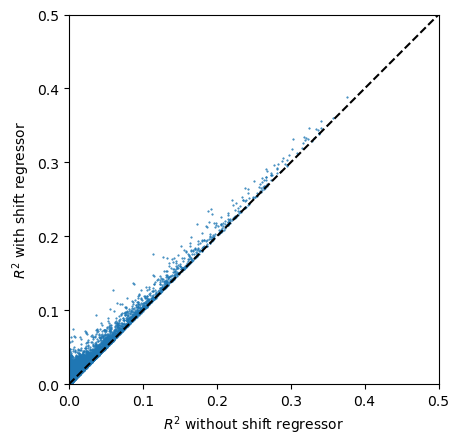

In [28]:
plt.plot(r2, r2_with_shift, ".", markersize=1)
plt.xlabel("$R^2$ without shift regressor")
plt.ylabel("$R^2$ with shift regressor")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.gca().set_aspect("equal", adjustable="box")

For most pixels, this doesn't make a big difference, but some see quite a large shift in $R^2$. To interpret the weights, we'll need to translate linear combinations of weights to time delays. The fraction $\frac{\beta_{hrf'}}{\beta_{hrf}}$ should correspond to the time shift $-\tau$; let's call that the **shift coefficient**.

Recall that our contention was that:

$$f(t - \tau) \approx f(t) - \tau f'(t) + \ldots$$

Let's double check how good this approximation is:

Text(0.5, 1.0, 'HRF Peak Time vs Shift Coefficient')

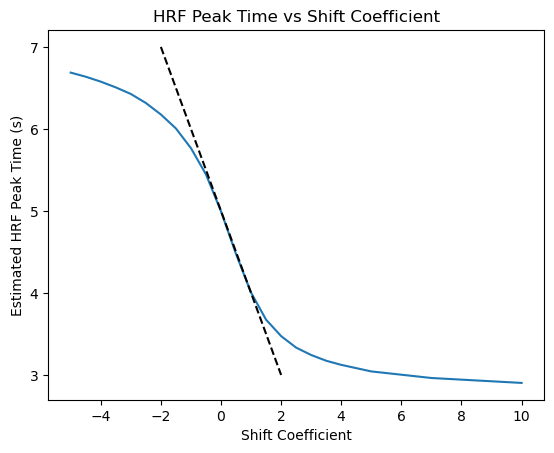

In [29]:
t_hi = np.linspace(0, 10, 1000)
hrf_hi, hrf_dt_hi, hrf_ddt = canonical_hrf_and_derivs_scipy(t_hi)

peak_times = []
for shift in np.linspace(-5, 10, 31):
    peak_time = t_hi[np.argmax(hrf_hi + hrf_dt_hi * shift)]
    peak_times.append(peak_time)
plt.plot(np.linspace(-5, 10, 31), peak_times)
plt.xlabel("Shift Coefficient")
plt.ylabel("Estimated HRF Peak Time (s)")
plt.plot([-2, 2], [7, 3], "k--")
plt.title("HRF Peak Time vs Shift Coefficient")

The approximation is fairly good between -0.5 and 1.0. Now let's look at the distribution of shift coefficients:

Text(0.5, 1.0, 'Shift coefficient histogram')

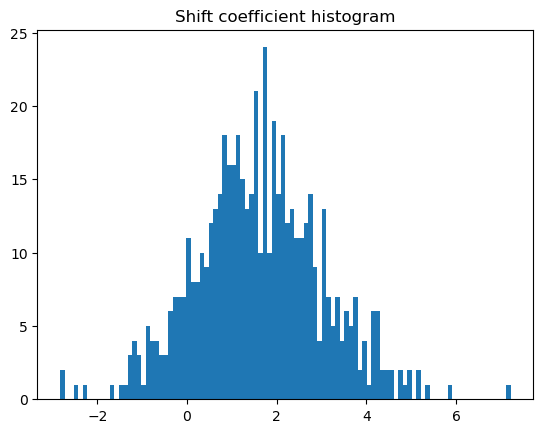

In [30]:
shift_coefficient = B[1, :] / B[0, :]
_ = plt.hist(shift_coefficient[r2 > 0.1], bins=100)
plt.title("Shift coefficient histogram")

These shifts look very large! Indeed, they look like they're mostly outside of the range of the validity of the approximation. What's going on here? Before we dive into that, let's check that this is not just random noise.

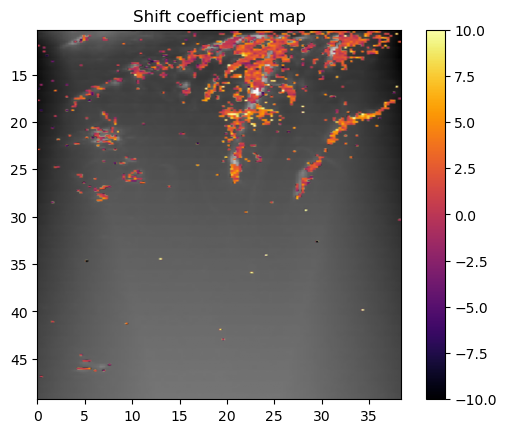

In [31]:
threshold = 0.05  # Totally arbitrary
meets_threshold = 1.0 * ((1 - residuals / residuals_baseline) > threshold)

plt.imshow(
    m_els.mean(axis=0),
    cmap="gray",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.imshow(
    shift_coefficient.reshape(m_els.shape[1], m_els.shape[2]),
    alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]),
    clim=(-10, 10),
    cmap="inferno",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("Shift coefficient map")
plt.colorbar()

This is interesting: there's some strong spatial correlations in the sign of the shift coefficient. The shift coefficient is mostly negative inside the big artery in the sulcus; and it looks positive right outside it. So it looks there's some structure to this effect. Let's look back at our regressors:

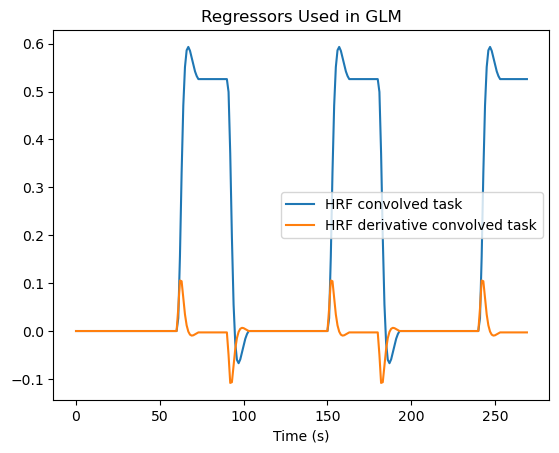

In [32]:
plt.plot(r_hrf, label="HRF convolved task")
plt.plot(r_hrfp, label="HRF derivative convolved task")
plt.xlabel("Time (s)")
plt.title("Regressors Used in GLM")
plt.legend()

We see something very interesting: the regressor associated with the derivative of the HRF shows blips around the start and end of the task periods. So what *could* be happening is that instead of the HRF being massively shifted for some pixels, some pixels display transient responses around the start and end of the task periods. Let's verify this with an alternative parametrization:

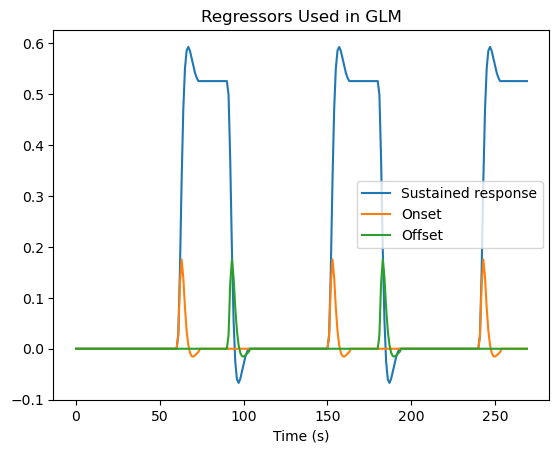

In [33]:
task = f["task"][:][:, 0]
task_onsets = np.where(np.diff(task) > 0)[0] + 1
task_offsets = np.where(np.diff(task) < 0)[0] + 1
task_onset_vector = np.zeros_like(task)
task_offset_vector = np.zeros_like(task)
task_onset_vector[task_onsets] = 1
task_offset_vector[task_offsets] = 1

r_sustained = scipy.signal.convolve(task, hrf, mode="full")[: len(f["task"])]
r_onset = scipy.signal.convolve(task_onset_vector, hrf, mode="full")[: len(f["task"])]
r_offset = scipy.signal.convolve(task_offset_vector, hrf, mode="full")[: len(f["task"])]

plt.plot(r_sustained, label="Sustained response")
plt.plot(r_onset, label="Onset")
plt.plot(r_offset, label="Offset")
plt.xlabel("Time (s)")
plt.title("Regressors Used in GLM")
plt.legend()

In [34]:
Y = m_els.reshape(m_els.shape[0], -1)
Y = Y / Y.std(axis=0)
X = np.vstack(
    [
        r_sustained,
        r_onset,
        r_offset,
        np.ones_like(r_offset),
        np.arange(len(r_offset)) / len(r_offset),
    ]
).T

B, residuals, rank, s = lstsq(X, Y, rcond=None)
B_baseline, residuals_baseline, rank, s = lstsq(X[:, -2:], Y, rcond=None)
r2_periods = 1 - residuals / residuals_baseline

Text(0.5, 1.0, 'Comparison of $R^2$ Values')

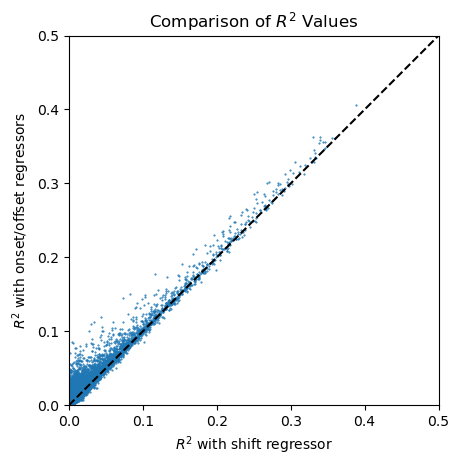

In [35]:
plt.plot(r2_with_shift, r2_periods, ".", markersize=1)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0, 0.5])
plt.ylim([0, 0.5])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("$R^2$ with shift regressor")
plt.ylabel("$R^2$ with onset/offset regressors")
plt.title("Comparison of $R^2$ Values")

Indeed, it does look like this might be what's going on.

movie(0.54118297)

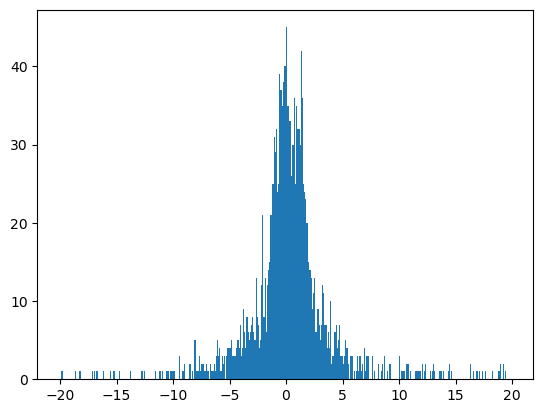

In [36]:
onset_coefficients = B[2, :] / B[1, :]
_ = plt.hist(onset_coefficients[r2_periods > 0.05], bins=np.arange(-20, 20, 0.1))

a = onset_coefficients[r2_periods > 0.05]
(a > 0).mean()

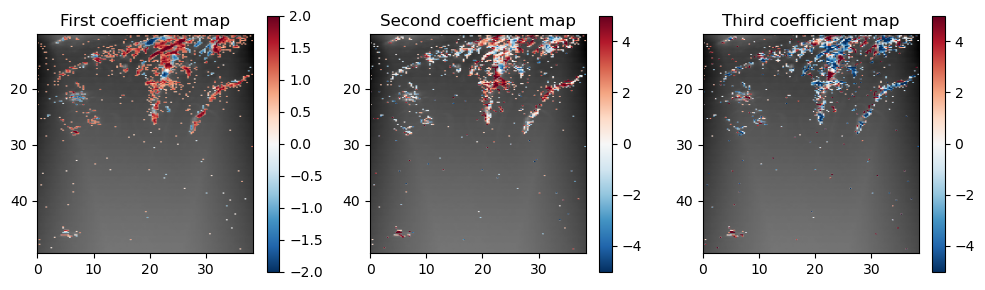

In [37]:

threshold = 0.05  # Totally arbitrary
meets_threshold = 1.0 * ((1 - residuals / residuals_baseline) > threshold)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(
    m_els.mean(axis=0),
    cmap="gray",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.imshow(
    B[0, :].reshape(m_els.shape[1], m_els.shape[2]),
    alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]),
    clim=(-2, 2),
    cmap="RdBu_r",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("First coefficient map")
plt.colorbar()

plt.subplot(132)
plt.imshow(
    m_els.mean(axis=0),
    cmap="gray",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.imshow(
    B[1, :].reshape(m_els.shape[1], m_els.shape[2]),
    alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]),
    clim=(-5, 5),
    cmap="RdBu_r",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("Second coefficient map")
plt.colorbar()

plt.subplot(133)
plt.imshow(
    m_els.mean(axis=0),
    cmap="gray",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.imshow(
    B[2, :].reshape(m_els.shape[1], m_els.shape[2]),
    alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]),
    clim=(-5, 5),
    cmap="RdBu_r",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("Third coefficient map")
plt.colorbar()

plt.tight_layout()

We see that most of the pixels which are modulated by the task are around the visible arteries.

# What about p-values?

Are these $R^2$ values good? I'm not a big fan of using p-values as a litmus test to determine whether a model is "significant" or not. It is, however, useful to get at least some idea of whether or not our model is better than the null. We can scramble or time-shift the design matrix to obtain a null distribution and calculate a p-value from that; alternatively, we can use a classical test like the F-test.

In [38]:

F_obs = ((residuals_baseline - residuals) / 3) / (residuals / (Y.shape[0] - X.shape[1]))
d1 = 3
d2 = Y.shape[0] - d1 - 1

Text(0.5, 1.0, 'F stat distribution vs. observed statistics')

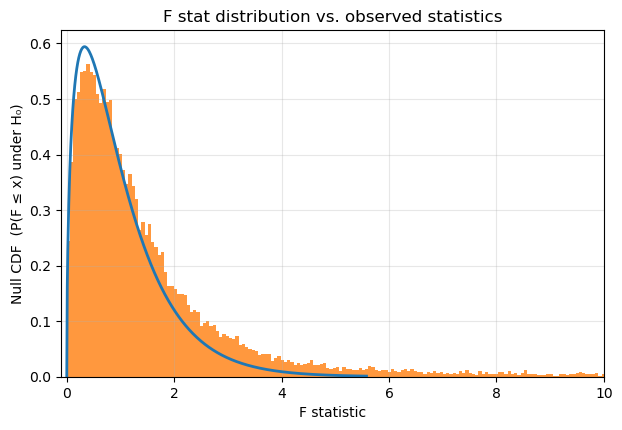

In [39]:
# x-range (up to ~99.9th percentile so the CDF reaches ~1)
xmax = scipy.stats.f.ppf(0.999, d1, d2)
xs = np.linspace(0, xmax, 600)

# null CDF under H0
cdf = scipy.stats.f.pdf(xs, d1, d2)  # F_{d1,d2}(x)

plt.figure(figsize=(7, 4.5))
plt.plot(xs, 0.82 * cdf, linewidth=2)
plt.xlabel("F statistic")
plt.ylabel("Null CDF  (P(F ≤ x) under H₀)")
plt.grid(True, alpha=0.3)
_ = plt.hist(F_obs, bins=1000, density=True, alpha=0.8, label="Observed F statistics")
plt.xlim((-0.1, 10))
plt.title(f"F stat distribution vs. observed statistics")

As we can see, there's a lot of excess weight on the right side of the distribution compared to the null F-distribution. Those correspond to R^2 values greater than expected by chance, i.e. significantly modulated pixels.

Great, now let's see some p-values.

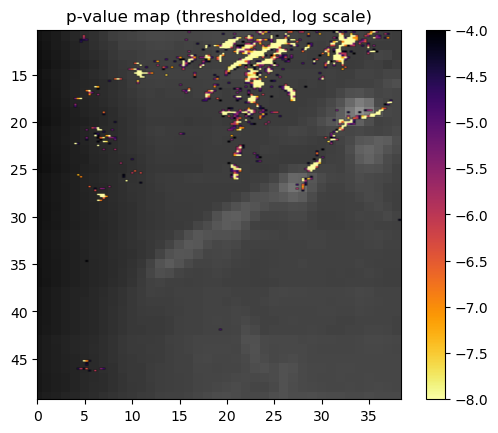

In [40]:
p = scipy.stats.f.sf(F_obs, dfn=d1, dfd=d2)
threshold = 0.0001  # Totally arbitrary
meets_threshold = 1.0 * (p < threshold)

plt.imshow(m_els.mean(axis=0), cmap="gray")
plt.imshow(
    (np.log10(p)).reshape(m_els.shape[1], m_els.shape[2]),
    alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]),
    clim=(np.log10(1e-8), np.log10(threshold)),
    cmap="inferno_r",
    extent=[0, dop_data_cropped.shape[2] * x_pixelsize, z_rg[1], z_rg[0]],
    aspect="equal",
)
plt.title("p-value map (thresholded, log scale)")
plt.colorbar()

No surprise here, we find that the computed p-values are tiny around the arteries in the volume.

# References

* [Rabut et al. 2024](https://www.biorxiv.org/content/10.1101/2023.06.14.544094v1.full.pdf). *A window to the brain: ultrasound imaging of human neural activity through an acoustically transparent cranial prosthetic*